In [1]:
!pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.0.0/fr_core_news_sm-3.0.0.tar.gz
!pip install transformers
!pip install imblearn
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 61.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from BertClassifier import BertClassifier
from RobertaClassifier import RobertaClassifier
from FunctionUtil import *

from tqdm import tqdm
import os

In [3]:
results_list = []

Je dois lire tout dabord la data ainsi que traiter la data pour cree l'entrer et la sortie

In [4]:
dataset = pd.read_csv("dataset.csv")
dataset.head()

,Clé,Résumé,Projet,Responsable,État,Versions corrigées,Epic Link,Lot de commande,Créateur,Type de ticket,...,Référent Développement,Date de Livraison estimée,Date de Livraison réelle,Référent étude TMA,Chiffrage TMA JH,Versions affectées,Description,Description US,Critères d’acceptation,Résumé du ticket
0,SIG-13999,[OGR] Amélioration de la prise en charge des p...,FP1087 - Sujet metier SIG 2024 S1,Ayoub ELJADID,En étude,SIG V24.5,PE-2117,Non_Défini,Anthony Dupuis,Story,...,Ayoub ELJADID,NaN,NaN,Ayoub ELJADID,NaN,SIG V24.5,NaN,{panel:bgColor=#e3fcef}\n*Contexte* : \n\nAvan...,||*Cas d'utilisation*||\n|{panel:bgColor=#e3fc...,NaN
1,SIG-13955,[FP1186 - Plan de remédiation SIG 2024] Suppre...,FP1186 - Petites corrections de vulnérabilités...,Ali Benhaddou,En étude,SIG V24.5,PE-2063,Non_Défini,Ali Benhaddou,Story,...,Paul-Antoine SALVETTI,NaN,NaN,Jean-Michel FORHAN,NaN,SIG V24.5,NaN,{panel:bgColor=#e3fcef}\n*Contexte* : Dans le ...,||*Cas d'utilisation*||\n|{panel:bgColor=#e3fc...,NaN
2,SIG-13952,[FP1186 - Plan de remédiation SIG 2024] [Etude...,FP1186 - Petites corrections de vulnérabilités...,Ali Benhaddou,En étude,SIG V24.5,PE-2063,Non_Défini,Ali Benhaddou,Etude,...,Paul-Antoine SALVETTI,NaN,NaN,Paul-Antoine SALVETTI,NaN,SIG V24.5,NaN,{panel:bgColor=#e3fcef}\n*Contexte* : Dans le ...,||*Cas d'utilisation*||\n|{panel:bgColor=#e3fc...,NaN
3,SIG-13949,[FP1186 - Plan de remédiation SIG 2024] Modifi...,FP1186 - Petites corrections de vulnérabilités...,Ali Benhaddou,En étude,SIG V24.5,PE-2063,Non_Défini,Ali Benhaddou,Story,...,Paul-Antoine SALVETTI,NaN,NaN,Jean-Michel FORHAN,NaN,SIG V24.5,NaN,{panel:bgColor=#e3fcef}\n*Contexte* : Dans le ...,||*Cas d'utilisation*||\n|{panel:bgColor=#e3fc...,NaN
4,SIG-13948,FP-968 - Décommissionnement des appels sortant...,FE968 - Process recouvrement clients particuli...,Gildas MOEVI,En étude,SIG V24.5,PE-2071,Non_Défini,Gildas MOEVI,Story,...,NaN,NaN,NaN,Nassima BENGUERNANE,1,SIG V24.5,NaN,{panel:bgColor=#e3fcef}\n*Contexte* : \n\nLe c...,||*Cas d'utilisation*||\n|{panel:bgColor=#e3fc...,*Contexte*\r\nLors du processus de recouvremen...


In [5]:
def preprocess_dataset(dataset):
    # Suppression des lignes avec des valeurs NaN dans 'Chiffrage TMA JH'
    dataset_filtered = dataset.dropna(subset=['Chiffrage TMA JH'])

    # Combinaison des données souhaitées dans une nouvelle colonne 'entry'
    dataset_filtered['entry'] = dataset_filtered['Projet'] + " " + dataset_filtered['Critères d’acceptation'] + " " + dataset_filtered['Description US']

    # Catégorisation du chiffrage
    def categorize_chiffrage(value):
        if value <= 3:
            return 'Petit'
        elif value <= 8:
            return 'Moyen'
        else:
            return 'Long'

    # Remplacement des virgules par des points et conversion en float
    dataset_filtered['Chiffrage TMA JH'] = dataset_filtered['Chiffrage TMA JH'].str.replace(',', '.').astype(float)

    # Application de la catégorisation
    dataset_filtered['Chiffrage Catégorie'] = dataset_filtered['Chiffrage TMA JH'].apply(categorize_chiffrage)


    return dataset_filtered[['entry', 'Chiffrage Catégorie']]

In [6]:
dataset_processed = preprocess_dataset(dataset)
dataset_processed.head()

/tmp/ipykernel_1265/1465547059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_filtered['entry'] = dataset_filtered['Projet'] + " " + dataset_filtered['Critères d’acceptation'] + " " + dataset_filtered['Description US']
/tmp/ipykernel_1265/1465547059.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_filtered['Chiffrage TMA JH'] = dataset_filtered['Chiffrage TMA JH'].str.replace(',', '.').astype(float)
/tmp/ipykernel_1265/1465547059.py:21: SettingWithCopyWarning: 
A value is trying to 

,entry,Chiffrage Catégorie
4,FE968 - Process recouvrement clients particuli...,Petit
14,FP1085 - Petits sujets techniques SIG S1 2024 ...,Petit
15,FP1085 - Petits sujets techniques SIG S1 2024 ...,Moyen
17,FE1000 - Archivage/suppression des données cli...,Moyen
18,FP1054 - Evolutions iR C24 ||*Cas d'utilisatio...,Long


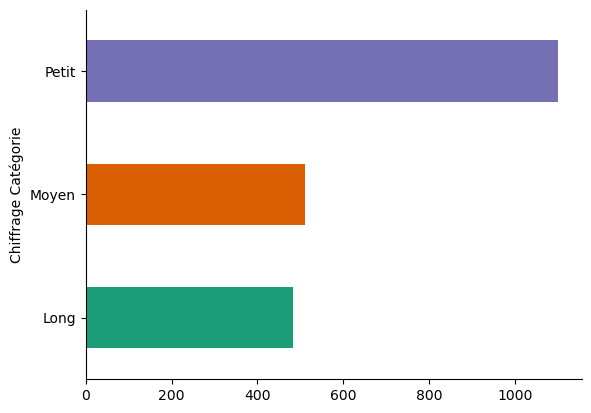

In [7]:
# @title Chiffrage Catégorie

from matplotlib import pyplot as plt
import seaborn as sns
dataset_processed.groupby('Chiffrage Catégorie').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

ici on traite la data afin de  recuperer just les informations importantes : par exemple suprimer les |{panel:bgColor=#e3fcef} dans le premier entry


In [8]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("fr_core_news_sm")
nlp.tokenizer = Tokenizer(nlp.vocab)

In [9]:
documents = []
import multiprocessing

max_processes = multiprocessing.cpu_count()

for doc in nlp.pipe([str(r) for r in dataset_processed['entry']] , n_process=max_processes-1, batch_size=1000):
    documents.append(' '.join([tok.lemma_ for tok in doc if not tok.is_stop and tok.is_alpha]))

In [10]:
cv = CountVectorizer(max_features = 1500)
x_Entry = cv.fit_transform(documents).toarray()
y_Output = dataset_processed["Chiffrage Catégorie"]


In [11]:
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Entry, y_Output, test_size=0.3)


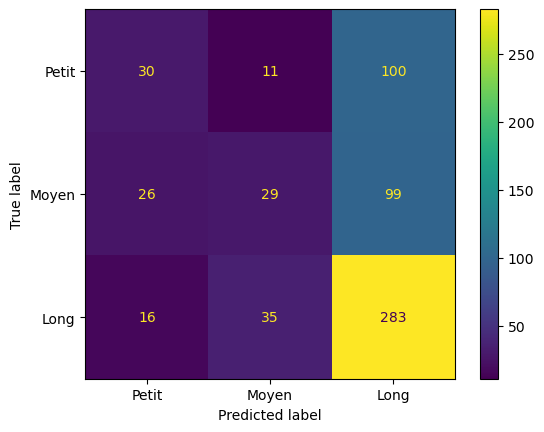

Precision per class:
 [0.41666667 0.38666667 0.58713693]
Recall per class:
 [0.21276596 0.18831169 0.84730539]
F1 Score per class:
 [0.28169014 0.25327511 0.69362745]
Weighted F1 Score: 0.4934725680426597


In [12]:
classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)
metrics(test_labels, y_pred,'MultinomialNB Classic',results_list)

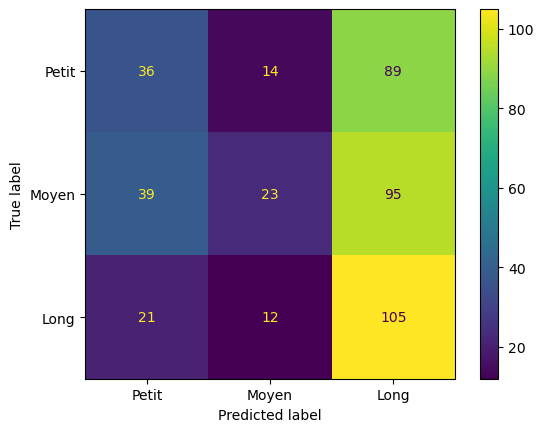

Precision per class:
 [0.375      0.46938776 0.3633218 ]
Recall per class:
 [0.25899281 0.14649682 0.76086957]
F1 Score per class:
 [0.30638298 0.22330097 0.49180328]
Weighted F1 Score: 0.3352864952275439


In [13]:
x_Review_undersampled , y_Votes_undersampled  = undersample_data(x_Entry, y_Output)
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Review_undersampled, y_Votes_undersampled, test_size=0.3)
classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)
metrics(test_labels, y_pred,'MultinomialNB Undersampled',results_list)


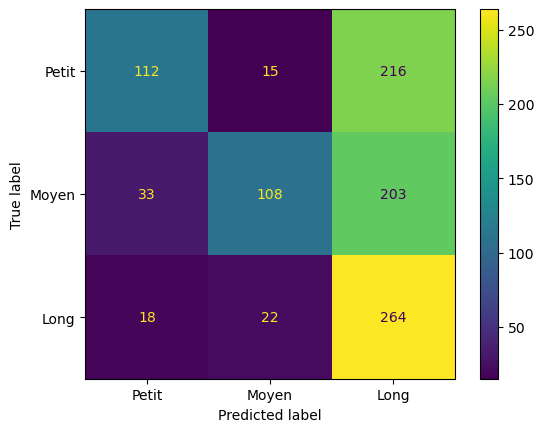

Precision per class:
 [0.68711656 0.74482759 0.38653001]
Recall per class:
 [0.32653061 0.31395349 0.86842105]
F1 Score per class:
 [0.44268775 0.44171779 0.53495441]
Weighted F1 Score: 0.4706548509548229


In [14]:
x_Review_oversampled , y_Votes_oversampled   = oversample_data(x_Entry, y_Output)
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Review_oversampled, y_Votes_oversampled, test_size=0.3)

classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)

metrics(test_labels, y_pred,'MultinomialNB Oversampled',results_list )

In [15]:
import torch
def convert_to_numeric_categories(categories):
    numeric_labels = []
    for label in categories:
        if label == 'Petit':
            numeric_labels.append(0)
        elif label == 'Moyen':
            numeric_labels.append(1)
        elif label == 'Long':
            numeric_labels.append(2)
    return numeric_labels

entry =[str(i) for i in dataset_processed["entry"]]
output =convert_to_numeric_categories(dataset_processed["Chiffrage Catégorie"])
train_texts, test_texts, train_labels, test_labels = train_test_split(entry, output, test_size=0.3)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('GPU not available, using CPU instead.')


GPU: Tesla T4


In [16]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
classifier_bert = BertClassifier('./models/bert_model.pth')
classifier_bert.train(train_texts, train_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 92/92 [02:00<00:00,  1.31s/it]


Training Loss: 1.0382127023261527


Epoch 2/3: 100%|██████████| 92/92 [02:02<00:00,  1.33s/it]


Training Loss: 1.0337847568418668


Epoch 3/3: 100%|██████████| 92/92 [02:02<00:00,  1.33s/it]


Training Loss: 1.026325396221617
Model saved successfully.


In [17]:
all_labels, all_predictions = classifier_bert.evaluate(test_texts, test_labels)
classifier_bert.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_bert_model.csv')

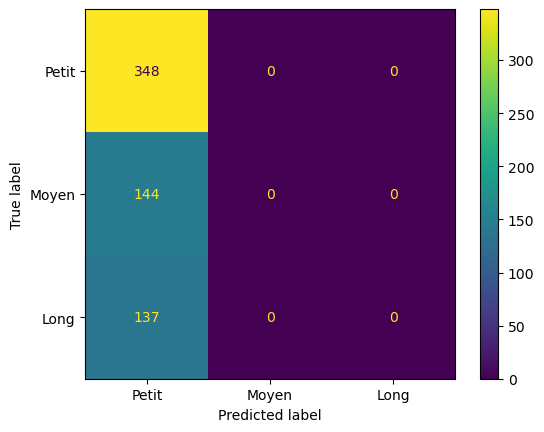

Precision per class:
 [0.55325914 0.         0.        ]
Recall per class:
 [1. 0. 0.]
F1 Score per class:
 [0.71238485 0.         0.        ]
Weighted F1 Score: 0.394133431402382


/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
metrics(all_labels, all_predictions,'Bert',results_list )
